#Task-2: Stock Market Prediction And Forecasting Using Stacked LSTM
#AUTHOR: Aditya Gurav
Importing packages

In [3]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

In [5]:
ds = pd.read_csv("https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv")
ds = ds.loc[::-1]
ds.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56
2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98


In [6]:
if(ds.isnull().sum().any() == 0):
    print("No null value is present")
else:
    print("Some data cleaning needs to be done!!")

No null value is present


In [7]:
ds.isnull().sum()

Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

In [8]:
ds.shape #(rows,col..)

(2035, 8)

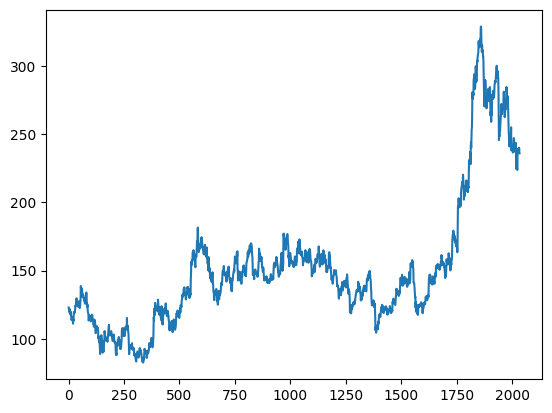

In [9]:
ds_high = ds.reset_index()['High'] #reset the index back to the default 0, 1, 2 etc
plt.plot(ds_high)
plt.show()

In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

sc = MinMaxScaler(feature_range= (0,1))
ds_high = sc.fit_transform(np.array(ds_high).reshape(-1,1))

#SPLITTING DATASET

In [11]:
train_size = int(len(ds_high)*0.75)
test_size = len(ds_high)-train_size

In [12]:
train_data = ds_high[0:train_size,:]
test_data = ds_high[train_size:len(ds_high),:1]

In [13]:
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [14]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [15]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

print("X train shape:",x_train.shape)
print("y train shape:",y_train.shape)

print("X test shape:",x_test.shape)
print("y test shape:",y_test.shape)

X train shape: (1425, 100, 1)
y train shape: (1425,)
X test shape: (408, 100, 1)
y test shape: (408,)


#Creating the LSTM model

In [16]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,LSTM

lstm = Sequential()
lstm.add(LSTM(50, return_sequences = True,input_shape = (100,1)))
lstm.add(LSTM(50,return_sequences = True))
lstm.add(LSTM(50))

lstm.add(Dense(1))
lstm.compile(loss = "mean_squared_error",optimizer = "adam")

In [17]:
lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [18]:
lstm.fit(x_train,y_train,validation_data = (x_test,y_test),epochs = 100,batch_size = 64,verbose = 1)

Epoch 1/100
23/23 [==============================] - 20s 522ms/step - loss: 0.0110 - val_loss: 0.0384
Epoch 2/100
23/23 [==============================] - 14s 637ms/step - loss: 0.0018 - val_loss: 0.0033
Epoch 3/100
23/23 [==============================] - 11s 427ms/step - loss: 8.3747e-04 - val_loss: 0.0031
Epoch 4/100
23/23 [==============================] - 11s 483ms/step - loss: 8.1264e-04 - val_loss: 0.0029
Epoch 5/100
23/23 [==============================] - 11s 482ms/step - loss: 7.3036e-04 - val_loss: 0.0028
Epoch 6/100
23/23 [==============================] - 11s 479ms/step - loss: 7.1664e-04 - val_loss: 0.0029
Epoch 7/100
23/23 [==============================] - 11s 481ms/step - loss: 6.6253e-04 - val_loss: 0.0046
Epoch 8/100
23/23 [==============================] - 11s 470ms/step - loss: 6.4492e-04 - val_loss: 0.0033
Epoch 9/100
23/23 [==============================] - 11s 456ms/step - loss: 5.9905e-04 - val_loss: 0.0030
Epoch 10/100
23/23 [==============================] - 

In [19]:
train_pred = lstm.predict(x_train)
test_pred = lstm.predict(x_test)

In [20]:
train_pred = sc.inverse_transform(train_pred)
test_pred = sc.inverse_transform(test_pred)

In [21]:
math.sqrt(mean_squared_error(y_train,train_pred)) #RMSE performance metrics

135.88126323368377

In [22]:
math.sqrt(mean_squared_error(y_test,test_pred)) #RMSE test data

227.23743274347234

#Plotting

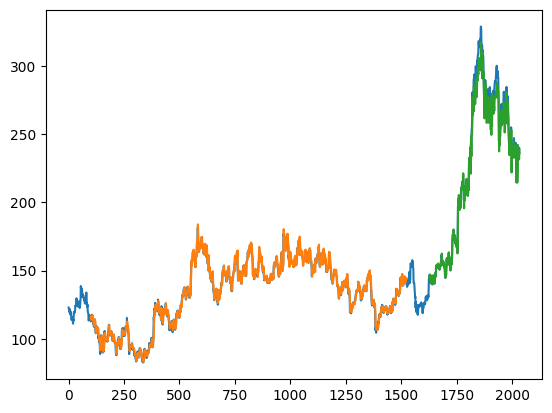

Green : Predicted data
Blue: Complete data
Orange: Train data


In [23]:
#shift train prediction for plotting
look_back = 100
trainPredictPlot = np.empty_like(ds_high)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(train_pred) + look_back,:] = train_pred

#shift test prediction for plotting
testPredictPlot = np.empty_like(ds_high)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_pred) +  (look_back * 2)+1:len(ds_high) - 1, :] = test_pred

#plot baseline and predictions
plt.plot(sc.inverse_transform(ds_high))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

print("Green : Predicted data")
print("Blue: Complete data")
print("Orange: Train data")

In [24]:
len(test_data),x_test.shape #predict the next 28 days stock price

(509, (408, 100, 1))

In [25]:
x_input = test_data[409:].reshape(1,-1)
x_input.shape

(1, 100)

In [26]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 100
nextNumberOfDays = 28
i = 0

while(i < 28):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = lstm.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i+1

    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = lstm.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[0.6103452]
101
1 day input [0.86013417 0.85464525 0.84448059 0.8072779  0.71843871 0.66192316
 0.67696686 0.67554381 0.67310429 0.68428542 0.68936776 0.70217524
 0.71803212 0.72941655 0.73144948 0.74486684 0.76926205 0.75991055
 0.74242732 0.73958122 0.74771295 0.75991055 0.7584875  0.76621264
 0.75462492 0.76316324 0.79670665 0.80585485 0.7889815  0.78003659
 0.73978451 0.73002643 0.73490547 0.74872942 0.75991055 0.75462492
 0.75401504 0.76174019 0.7737345  0.82008538 0.80585485 0.81154706
 0.77434438 0.78633869 0.79284407 0.78328929 0.77109169 0.74385038
 0.71193332 0.68733482 0.67818662 0.65257166 0.64301687 0.65643423
 0.67656028 0.67371417 0.65114861 0.65521447 0.66761537 0.67838992
 0.69993901 0.63122586 0.63508843 0.64098394 0.64545639 0.64118723
 0.63854442 0.63081927 0.62472047 0.6330555  0.64728603 0.6574507
 0.66761537 0.66720878 0.64159382 0.62776987 0.63651149 0.63630819
 0.62980281 0.62817646 0.63813783 0.65358813 0.63183574 0.57653995
 0.57816629 0.57613336 0.61943484 0

In [27]:
day_new = np.arange(1,101)
day_pred = np.arange(101,129)

In [28]:
day_new = np.arange(1,101)
day_pred = np.arange(101,129)

In [29]:
ds_new = ds_high.tolist()
ds_new.extend(lst_output)

len(ds_high)

2035

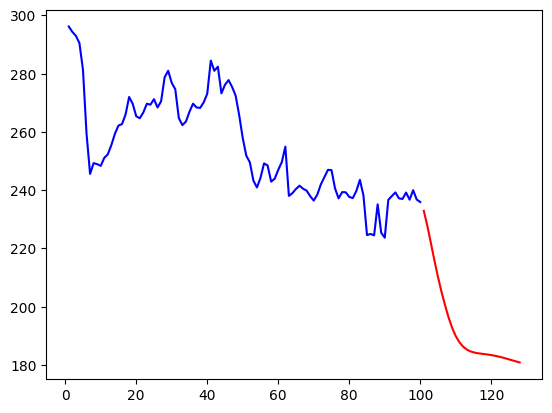

In [30]:
plt.plot(day_new,sc.inverse_transform(ds_high[1935:]),'b')
plt.plot(day_pred,sc.inverse_transform(lst_output),'r')
plt.show()

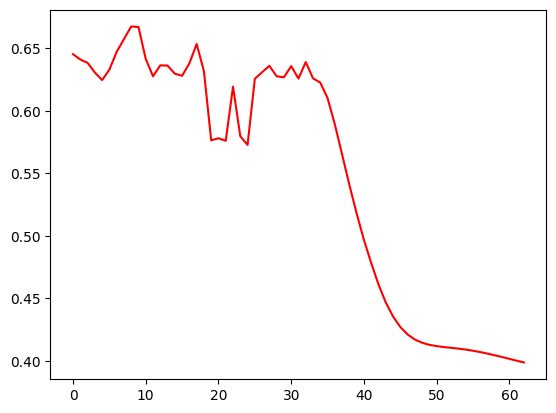

In [31]:
ds_new = ds_high.tolist()
ds_new.extend(lst_output)
plt.plot(ds_new[2000:],'r')
plt.show()

In [32]:
ds_new = sc.inverse_transform(ds_new).tolist()

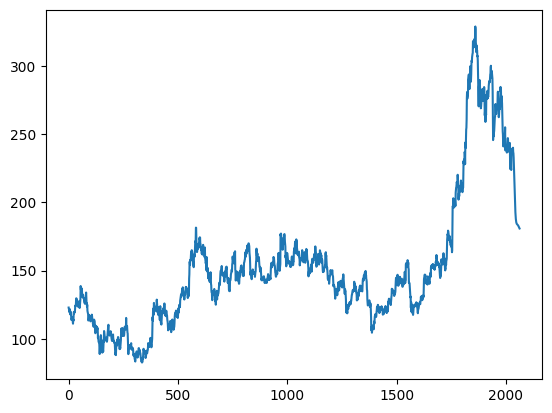

In [33]:
plt.plot(ds_new)
plt.show()